**Problem Overview**: The goal of this project is to build a client retention model for the IFSSA food hamper distribution program, which aims to predict whether a client will be retained or churned based on a combination of historical interaction data and environmental influences. Retention is classified into two categories: "retained" or "churned," with the target variable being the retention label.

**Machine Learning Model Type**: This is a classification task. We are interested in predicting the binary outcome ("retained" or "churned") based on historical behavior and external factors. The model will help identify at-risk clients, allowing the program to tailor its outreach strategies and services.

**Key Variable**:

Age and Family Size (age, dependents_qty): Age and family size affect a client’s need for hampers and their likelihood to continue using the service.

Location (location_cluster): The geographic region or neighborhood a client is in impacts their likelihood to be retained. Neighborhoods with higher levels of engagement or community support are more likely to see higher retention rates.

Pick up Dates: Clients who have gone without receiving a hamper for a significant period of time are more likely to churn. Tracking the time since the last visit helps gauge a client’s current engagement.

External Sources of Influence:
Geographic Factors:

Neighborhood-Level Engagement: The geographic location of clients can significantly affect retention. Areas with higher density or more active community engagement might have higher retention rates.By aggregating the number of visits per neighborhood, we can understand how well a region is served and whether some neighborhoods are more reliant on the program than others.
Unique Clients Per Neighborhood: This feature allows us to understand client density in each area. More densely populated or active areas may have more clients but may also have more churn.

Geographic Clusters (e.g., location_cluster): This grouping can be used to evaluate neighborhood characteristics and create interaction features with other variables like visit frequency, retention status, or even demographic trends.
Holiday and Temporal Factors:

Public Holidays and Religious Events: Holidays, especially religious ones like Ramadan or Muslim holidays, can influence the frequency of hamper requests and the need for food. Clients may have a higher demand for food hampers during holiday seasons, which might temporarily increase their likelihood of retention.

Relevance of the Features:
Incorporating geographic and holiday-related features into the model adds valuable context for client behavior. Geographic factors help identify region-based trends, while holiday features allow the model to account for short-term spikes in demand and changing behavior around religious and cultural periods. These features give the model a more nuanced understanding of retention dynamics and enable it to better predict which clients are more likely to churn or be retained based on external influences.

By combining client-level behavior data (such as visit frequency and demographic attributes) with spatiotemporal influences (like neighborhood characteristics and holiday periods), we can create a more comprehensive model. This will allow us to understand not just how clients behave on their own, but how external factors shape their interaction with the food hamper program.



In [4]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import sklearn.tree as skTree
import sklearn.metrics as skMetrics
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
ohe = OneHotEncoder()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import FunctionTransformer
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut




In [5]:
%%capture
!pip install geopy

#**Block 2 - Time Based Features**

**The following features are engineered to capture temporal patterns in the dataset, allowing us to better understand client behaviors and demand trends over time. These time-based features provide valuable insights that can be incorporated into machine learning models for more accurate predictions and enhanced decision-making.**

**days_since_last_pickup**:
Tracks the number of days since the last pickup.
Purpose: Indicates client interaction frequency; frequent pickups suggest higher engagement.

**days_diff_scheduled_actual**:
Measures the difference between scheduled and actual pickup dates.
Purpose: Assesses service punctuality; large differences may indicate inefficiency.

**rescheduled_flag**:
Binary flag indicating if the pickup was rescheduled (1 = Yes, 0 = No).
Purpose: Flags clients with rescheduled pickups; may reflect client behavior or service issues.

**day_of_week:**
Extracts the day of the week from the pickup date.
Purpose: Identifies trends in client behavior based on days of the week.

**month**:
Extracts the month number from the pickup date.
Purpose: Captures seasonal trends in demand and client engagement.

**is_muslim_holiday**: Flags pickups that fall on either Eid al-Fitr or Eid al-Adha.

**is_ramadan_period**: Flags pickups that fall during the Ramadan fasting period.

**within_3_days_of_holiday**: Flags pickups that occur within 3 days before or after Eid holidays.

**during_ramadan**: Flags pickups that occur within 30 days after Ramadan's start.

In [6]:
# Import dataset
df = pd.read_csv('Cleaned_Hamper_Data.csv')

In [7]:
import pandas as pd

def create_time_features(df):

    # Ensure datetime format for both columns
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    df['collect_scheduled_date'] = pd.to_datetime(df['collect_scheduled_date'])

    # 1. Days Since Last Pickup (Per Row, No Aggregation)
    df = df.sort_values(by=['new_client_id', 'pickup_date'])  # Sort by client and pickup date
    df['days_since_last_pickup'] = df.groupby('new_client_id')['pickup_date'].diff().dt.days
    df['days_since_last_pickup'] = df['days_since_last_pickup'].fillna(0).astype(int)  # Replace NaN with 0

    # 2. Difference Between Scheduled & Actual Pickup
    df['days_diff_scheduled_actual'] = (df['pickup_date'] - df['collect_scheduled_date']).dt.days

    # 3. Is Rescheduled? (If Actual Pickup is different from Scheduled)
    df['rescheduled_flag'] = (df['pickup_date'] != df['collect_scheduled_date']).astype(int)

    # 4. Month Number (1 = Jan, 12 = Dec)
    df['month'] = df['pickup_date'].dt.month

    # 5. Total Number of Visits Per Client
    df['total_visits'] = df.groupby('new_client_id')['pickup_date'].transform('count')

    # 6. Average Days Between Pickups (Per Client)
    df['time_diff'] = df.groupby('new_client_id')['pickup_date'].diff().dt.days
    avg_days_between_pickups = df.groupby('new_client_id')['time_diff'].mean().reset_index()
    avg_days_between_pickups.rename(columns={'time_diff': 'avg_days_between_pickups'}, inplace=True)

    # Merge back with original DataFrame
    df = pd.merge(df, avg_days_between_pickups, on='new_client_id', how='left')

    # Drop temporary column
    df.drop(columns=['time_diff'], inplace=True)

    return df

# Apply function to Train and Test data
df = create_time_features(df)




In [8]:
# Get clients with null values in avg_days_between_pickups
clients_with_null_avg_days = df[df['avg_days_between_pickups'].isnull()]['new_client_id'].unique()

# Check the number of pickup records for these clien
pickup_counts = df.groupby('new_client_id')['pickup_date'].count()
pickup_counts_for_null_clients = pickup_counts[pickup_counts.index.isin(clients_with_null_avg_days)]

# Print the results
print(pickup_counts_for_null_clients)

new_client_id
1696013575591x992017097454009500    1
1696013579635x742428568482838900    1
1696013583193x520473794602795300    1
1696013585616x968202076139878100    1
1696013585786x726861356911853800    1
                                   ..
1723663312544x809010272694435800    1
1723754861552x584585952824655900    1
1724091138365x303829565397532700    1
1724097941351x759785133646282800    1
1724273888788x416608885384937500    1
Name: pickup_date, Length: 91, dtype: int64


In [9]:
df['is_single_pickup'] = df.groupby('new_client_id')['pickup_date'].transform('count') == 1


In [10]:
# Define the Ramadan dates for 2023–2025 (for reference, not as a holiday itself)
ramadan_dates = pd.to_datetime(['2023-03-22', '2023-04-21', '2024-03-10', '2024-04-10', '2025-02-28', '2025-03-29'])

# Define the Muslim holidays dates (Eid al-Fitr and Eid al-Adha)
eid_al_fitr_dates = pd.to_datetime(['2023-04-20', '2023-04-21', '2024-04-09', '2024-04-10', '2025-03-29', '2025-03-30'])
eid_al_adha_dates = pd.to_datetime(['2023-06-27', '2023-07-01', '2024-06-15', '2024-06-19', '2025-06-06', '2025-06-10'])

def add_holiday_flags_with_ramadan(df):
    # Ensure 'pickup_date' is in datetime format
    df['pickup_date'] = pd.to_datetime(df['pickup_date'], errors='coerce')

    # Combine the Eid al-Fitr and Eid al-Adha dates into a single list of holidays by converting them into Series
    all_holiday_dates = pd.concat([pd.Series(eid_al_fitr_dates), pd.Series(eid_al_adha_dates)])

    # 1. Flag if the pickup is on Eid al-Fitr or Eid al-Adha
    df['is_muslim_holiday'] = df['pickup_date'].isin(all_holiday_dates).astype(int)

    # 2. Flag if the pickup is during Ramadan (not as a holiday, just the fasting period)
    df['is_ramadan_period'] = df['pickup_date'].isin(ramadan_dates).astype(int)

    # 3. Flag if the pickup is within 3 days of Eid al-Fitr or Eid al-Adha
    df['within_3_days_of_holiday'] = df['pickup_date'].apply(
        lambda x: 1 if any(abs((eid - x).days) <= 3 for eid in all_holiday_dates) else 0
    )
# 4. Flag if the pickup is during Ramadan (considering a wider window for behavior patterns)
    df['during_ramadan'] = df['pickup_date'].apply(
        lambda x: 1 if any(
            [(r - x).days <= 30 for r in ramadan_dates if r > x]  # Corrected condition
        ) else 0
    )

    return df
    df['during_ramadan'] = df['pickup_date'].apply(
        lambda x: 1 if any((ramadan_dates[ramadan_dates > x].min() - x).days <= 30) else 0
    )

    return df

# Apply to your training and test data
df = add_holiday_flags_with_ramadan(df)


#**Block 3 -Client Based Features**

**Client-based features provide valuable insights into individual customer behavior, allowing for a more personalized understanding of how clients engage with the service over time. These features are key in identifying patterns such as frequent or occasional visits, the influence of dependents on demand, and how recent behaviors may predict future actions. Incorporating these features can enhance model accuracy by accounting for client-specific dynamics, ultimately improving predictions related to client retention, demand forecasting, and resource allocation.**

 **Hamper Demand by Client**
 This feature tracks the total number of visits (or pickups) made by each client, essentially quantifying their demand for hampers.
 It helps to identify clients who request hampers frequently and can provide insights into demand patterns. This feature is crucial for understanding the scale of demand per client, and it can help tailor services to more active clients or those with higher needs.

**Client-Based Features:**
Total Visits in Last 30 Days:
Counts the number of visits each client made in the last 30 days, reflecting recent engagement.

**Average Time Between Visits:**
Calculates the average gap between consecutive visits for each client, indicating how often they access the service.

**Visit Frequency Category**:
Classifies clients as 'Frequent', 'Occasional', or 'Rare' based on their total visit count relative to the median, providing insights into client loyalty and activity levels.

**Time Since First Visit**:
Measures the duration since each client's first visit, indicating their customer lifecycle stage and helping assess retention.

**Total Number of Dependents**:
Sums up the dependents for each client, which can reflect the client's household or family size and influence service demand.

**Recent Changes in Dependency (Last 30 Days)**:
Tracks changes in the number of dependents over the past 30 days, highlighting any recent shifts in client needs or family dynamics.

**Total Visits in Last 7, 14, 30, and 90 Days**

Tracks the total visits within specified timeframes (7, 14, 30, and 90 days), providing an in-depth view of recent and historical engagement.

In [12]:
# Count number of visits per client (based on pickup_date)
hamper_demand_per_client_train = df.groupby('new_client_id')['pickup_date'].count().reset_index()


# Rename column
hamper_demand_per_client.rename(columns={'pickup_date': 'hamper_visits'}, inplace=True)


# Merge with original DataFrames
df = pd.merge(df, hamper_demand_per_client, on='new_client_id', how='left')




NameError: name 'hamper_demand_per_client' is not defined

In [13]:
# Function to create client-based features
def create_client_based_features(df):
    # Ensure 'pickup_date' is in datetime format
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])

    # 1. Total Visits in Last 30 Days
    df['total_visits_last_30d'] = df.groupby('new_client_id')['pickup_date'].apply(
        lambda x: x[x >= (x.max() - pd.Timedelta(days=30))].count()
    ).reset_index(drop=True)

    # 2. Average Time Between Visits
    df['avg_time_between_visits'] = df.groupby('new_client_id')['pickup_date'].apply(
        lambda x: x.diff().dt.days.mean()
    ).reset_index(drop=True)

    # 3. Visit Frequency Category (categorize visits based on median)
    visit_counts = df.groupby('new_client_id')['pickup_date'].count()
    median_visits = visit_counts.median()
    df['visit_frequency_category'] = df['new_client_id'].map(
        lambda x: 'Frequent' if visit_counts[x] > median_visits else ('Occasional' if visit_counts[x] > visit_counts.min() else 'Rare')
    )

    # 4. Time Since First Visit
    df['time_since_first_visit'] = df.groupby('new_client_id')['pickup_date'].transform(
        lambda x: (x.max() - x.min()).days
    )

    # 5. Total Number of Dependents (sum of dependents over the available records)
    df['total_dependents'] = df.groupby('new_client_id')['dependents_qty'].transform('sum')

    # 6. Recent Changes in Dependency (change in dependents_qty over the past 30 days)
    def get_dependents_change(x):
        # Find the most recent date for the client
        max_date = x.max()

        # Filter records to include only those within the past 30 days
        last_30_days = x[x >= (max_date - pd.Timedelta(days=30))]

        # Calculate the change in dependents_qty over the past 30 days
        if len(last_30_days) > 1:  # Ensure there are at least two records for comparison
            return last_30_days.diff().iloc[-1]  # Difference in the last two records
        return np.nan

    # Apply the function to the groupby object
    df['dependents_change_last_30d'] = df.groupby('new_client_id')['pickup_date'].apply(
        lambda x: get_dependents_change(x)
    ).reset_index(drop=True)

    return df

# Apply to both train and test datasets
df = create_client_based_features(df)



In [14]:
import numpy as np
import pandas as pd

def create_client_based_features(df):
    # Ensure 'pickup_date' is in datetime format
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])

    # Sort by client and date
    df = df.sort_values(by=['new_client_id', 'pickup_date'])

    # Define timeframes
    timeframes = [7, 14, 30, 90]

    # Initialize visit count columns
    for days in timeframes:
        df[f'total_visits_last_{days}d'] = 0

    # Compute visit counts manually
    for client_id, group in df.groupby('new_client_id'):
        for days in timeframes:
            cutoff_date = group['pickup_date'].max() - pd.Timedelta(days=days)
            df.loc[group.index, f'total_visits_last_{days}d'] = (group['pickup_date'] >= cutoff_date).sum()

    # Average time between visits
    df['avg_time_between_visits'] = df.groupby('new_client_id')['pickup_date'].transform(lambda x: x.diff().dt.days.mean())

    # Visit frequency category
    visit_counts = df.groupby('new_client_id')['pickup_date'].count()
    median_visits = visit_counts.median()
    df['visit_frequency_category'] = df['new_client_id'].map(
        lambda x: 'Frequent' if visit_counts[x] > median_visits else ('Occasional' if visit_counts[x] > visit_counts.min() else 'Rare')
    )

    # Time since first visit
    df['time_since_first_visit'] = df.groupby('new_client_id')['pickup_date'].transform(lambda x: (x.max() - x.min()).days)

    # Total number of dependents
    df['total_dependents'] = df.groupby('new_client_id')['dependents_qty'].transform('sum')

    # Compute dependents change
    for days in timeframes:
        df[f'dependents_change_last_{days}d'] = df.groupby('new_client_id')['dependents_qty'].transform(
            lambda x: x.iloc[-1] - x.iloc[max(0, len(x)-days)]
        )

    return df

# Apply to both training and test datasets
df = create_client_based_features(df)



#**Block 4 - Geospatial Features**

**Geospatial patterns play a crucial role in our client retention problem by identifying areas with higher concentrations of frequent users and regions that may require more targeted outreach. Analyzing location-based trends allows for better churn prediction**

**Location Cluster**
 It allows for spatial analysis, enabling insights into the distribution of demand and client activity across different areas. This can help optimize resource allocation for service delivery.
**Unique Clients Per Neighborhood**
It helps to measure the  clients in each area, which could be useful for understanding the size of the client base in each neighborhood and predicting future demand.

**Total Visits Per Neighborhood**
This feature sums the total number of visits (or pickups) made in each neighborhood or location cluster.
It helps identify areas with higher service demand.

In [ ]:
pip install googlemaps


In [ ]:
import re

def extract_postal_code(address):
    """
    Extracts the Canadian postal code from an address string.

    Args:
        address (str): The address string.

    Returns:
        str: The postal code if found, otherwise None.
    """
    postal_code_pattern = r"[A-Z]\d[A-Z] ?\d[A-Z]\d"  # Canadian postal code pattern
    match = re.search(postal_code_pattern, address)
    if match:
        return match.group(0)
    else:
        return None

# Apply the function to the 'address' column in your DataFrame
df['postal_code'] = df['address'].apply(extract_postal_code)




In [ ]:
import googlemaps
import pandas as pd
import time

# Replace with your Google API Key
#GOOGLE_API_KEY = "space_for_api_key"



# Initialize Google Maps client
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

def get_coordinates_from_postal(postal_code, country="Canada"):  # Default country is Canada
    """
    Get latitude and longitude from postal code using Google Maps API.
    """
    try:
        geocode_result = gmaps.geocode(f"{postal_code}, {country}")
        if geocode_result:
            location = geocode_result[0]['geometry']['location']
            return pd.Series([location['lat'], location['lng']])
        else:
            return pd.Series([None, None])  # No result found
    except Exception as e:
        print(f"Error geocoding {postal_code}: {e}")
        return pd.Series([None, None])  # Handle API errors


# Apply the function to get latitude and longitude
df[['latitude', 'longitude']] = df['postal_code'].apply(get_coordinates_from_postal)





Error geocoding T5E 4C7: REQUEST_DENIED (You must enable Billing on the Google Cloud Project at https://console.cloud.google.com/project/_/billing/enable Learn more at https://developers.google.com/maps/gmp-get-started)
Error geocoding T5E 4C7: REQUEST_DENIED (You must enable Billing on the Google Cloud Project at https://console.cloud.google.com/project/_/billing/enable Learn more at https://developers.google.com/maps/gmp-get-started)
Error geocoding T5G 1Z2: REQUEST_DENIED (You must enable Billing on the Google Cloud Project at https://console.cloud.google.com/project/_/billing/enable Learn more at https://developers.google.com/maps/gmp-get-started)
Error geocoding T5G 1Z2: REQUEST_DENIED (You must enable Billing on the Google Cloud Project at https://console.cloud.google.com/project/_/billing/enable Learn more at https://developers.google.com/maps/gmp-get-started)
Error geocoding T5G 1Z2: REQUEST_DENIED (You must enable Billing on the Google Cloud Project at https://console.cloud.go

In [ ]:
# Create a dictionary mapping postal codes to coordinates
postal_code_coords = {
    "T5E 4C7": (53.5930843, -113.4916200),
    "T5G 1Z2": (53.5772506, -113.4915449),
    "T5H 2Z8": (53.5473390, -113.5058219),
    "T5C 1E8": (53.6091646, -113.4607291)

}

# Function to apply manual coordinates
def set_manual_coordinates(row):
    if row['postal_code'] in postal_code_coords:
        row['latitude'], row['longitude'] = postal_code_coords[row['postal_code']]
    return row

# Apply the function to the DataFrame
df = df.apply(set_manual_coordinates, axis=1)

In [ ]:
# drop postal code column
df.drop(columns=['postal_code'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt

# Define the distribution center coordinates
distribution_center_coords = (53.5486628, -113.5061059)  # IFSSA distribution center

# Function to calculate distance to distribution center
def calculate_distance(row, distribution_center):
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        client_coords = (row['latitude'], row['longitude'])
        return geodesic(client_coords, distribution_center).km
    return np.nan  # Return NaN if coordinates are missing

# Apply function to add distance feature
for df in [df]:
    df['distance_to_center'] = df.apply(lambda row: calculate_distance(row, distribution_center_coords), axis=1)

# Latitude/Longitude Clustering (Using KMeans)
for df in [df]:
    coordinates = df[['latitude', 'longitude']].dropna()  # Remove NaNs before clustering

    if len(coordinates) >= 5:  # Ensure at least 5 valid data points
        scaler = StandardScaler()
        coordinates_scaled = scaler.fit_transform(coordinates)

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        cluster_labels = pd.Series(kmeans.fit_predict(coordinates_scaled), index=coordinates.index)

        # Assign cluster labels back to the full dataset, filling NaN with -1
        df['location_cluster'] = cluster_labels.reindex(df.index, fill_value=-1).astype(int)
    else:
        df['location_cluster'] = -1  # Assign -1 if not enough data points for clustering


In [ ]:
# Group by 'location_cluster' and count unique clients
unique_clients_per_neighborhood = df.groupby('location_cluster')['new_client_id'].nunique().reset_index()
unique_clients_per_neighborhood.columns = ['location_cluster', 'unique_clients_per_neighborhood']

# Merge with Train_dataDC to add the new feature
df = df.merge(unique_clients_per_neighborhood, on='location_cluster', how='left')





In [ ]:
# Group by neighborhood (location_cluster) for Train and Test data
# Total visits per neighborhood for Train data
Total_visits_per_neighbourhood = df.groupby('location_cluster')['hamper_visits'].sum().reset_index()
Total_visits_per_neighbourhood.rename(columns={'hamper_visits': 'total_visits_train'}, inplace=True)



# Merge both summaries back to their respective datasets
df = pd.merge(df, Total_visits_per_neighbourhood, on='location_cluster', how='left')





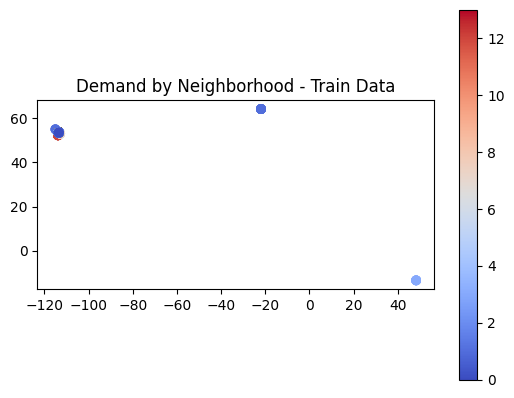

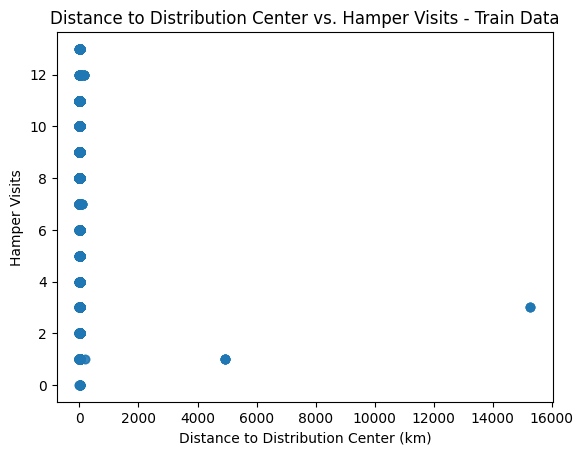

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import matplotlib.pyplot as plt



# Define the distribution center coordinates
distribution_center_coords = (53.5486628, -113.5061059)  #IFSSA distribution center

# Function to calculate distance to distribution center
def calculate_distance(row, distribution_center):
    # Check if latitude and longitude are valid (not NaN)
    if pd.notna(row['latitude']) and pd.notna(row['longitude']):
        client_coords = (row['latitude'], row['longitude'])
        dist = geodesic(client_coords, distribution_center).km
        return dist
    else:
        return np.nan  # Return NaN if coordinates are missing

# Add distance to the distribution center for both Train and Test data
for df in [df]:
    df['distance_to_center'] = df.apply(calculate_distance, axis=1, distribution_center=distribution_center_coords)

# Latitude/Longitude Clustering (Using KMeans)
for df in [df]:
    # Filter out rows with missing coordinates before clustering
    coordinates = df[['latitude', 'longitude']].dropna()
    scaler = StandardScaler()
    coordinates_scaled = scaler.fit_transform(coordinates)

    # Apply KMeans clustering to identify geographic regions
    kmeans = KMeans(n_clusters=5, random_state=42)

    # Assign cluster labels to the original DataFrame using index alignment
    df['location_cluster'] = pd.Series(kmeans.fit_predict(coordinates_scaled), index=coordinates.index)
    df['location_cluster'] = df['location_cluster'].fillna(-1).astype(int) # Fill NaN with -1 and convert to int

# Neighborhood-Level Demand Aggregation (For both Train and Test)
# Aggregating demand by geographic clusters for Train data
demand_by_neighborhood = df.groupby('location_cluster')['hamper_visits'].sum().reset_index()

# Visualizing the demand by geographic clusters (if you have a 'longitude' and 'latitude' column)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf.plot(column='hamper_visits', cmap='coolwarm', legend=True)
plt.title('Demand by Neighborhood - Train Data')
plt.show()

# 4. Visualizing Distance to Distribution Center vs. Demand for Train Data
plt.scatter(df['distance_to_center'], df['hamper_visits'], alpha=0.5)
plt.title('Distance to Distribution Center vs. Hamper Visits')
plt.xlabel('Distance to Distribution Center (km)')
plt.ylabel('Hamper Visits')
plt.show()

# Save the processed data with new features for both Train and Test data
df.to_csv('processed__data.csv', index=False)





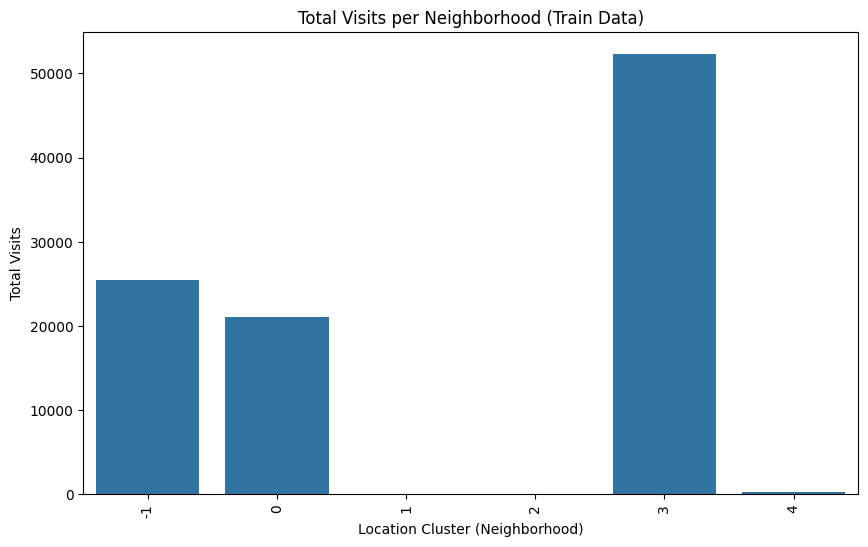

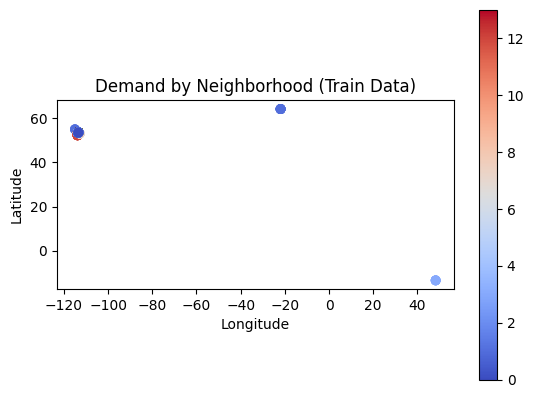

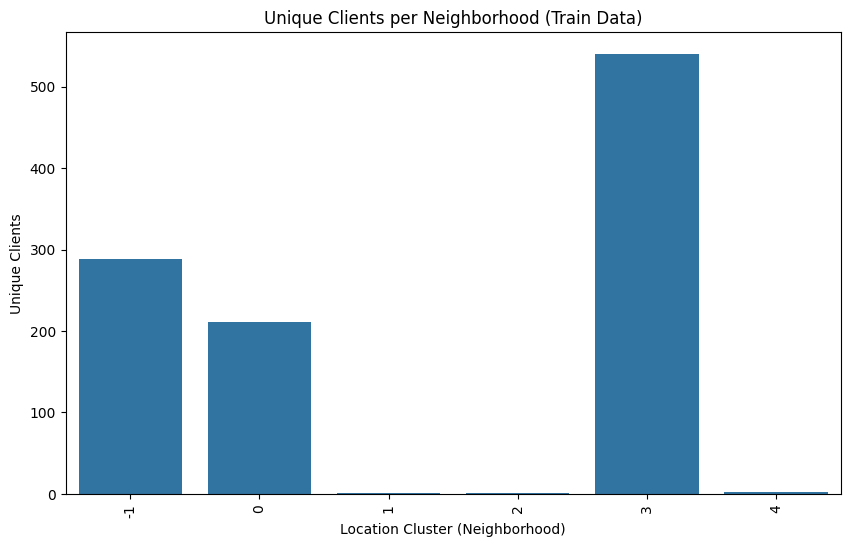

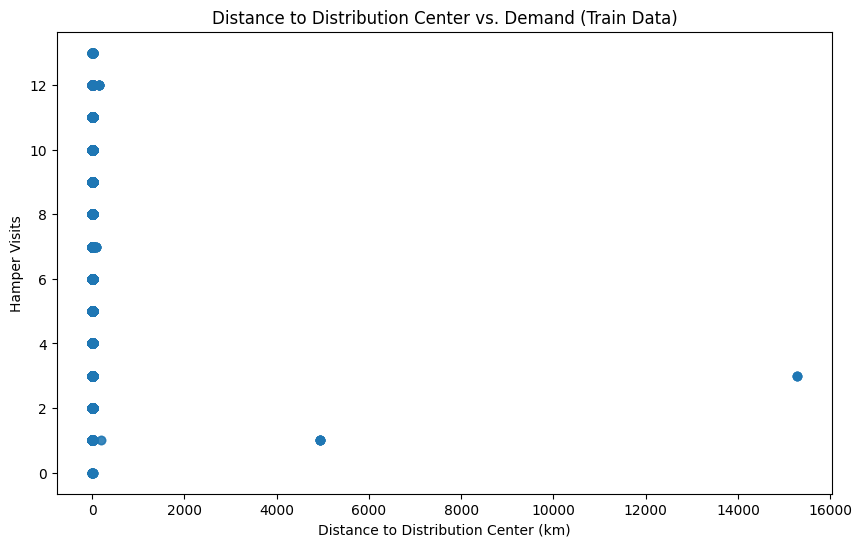

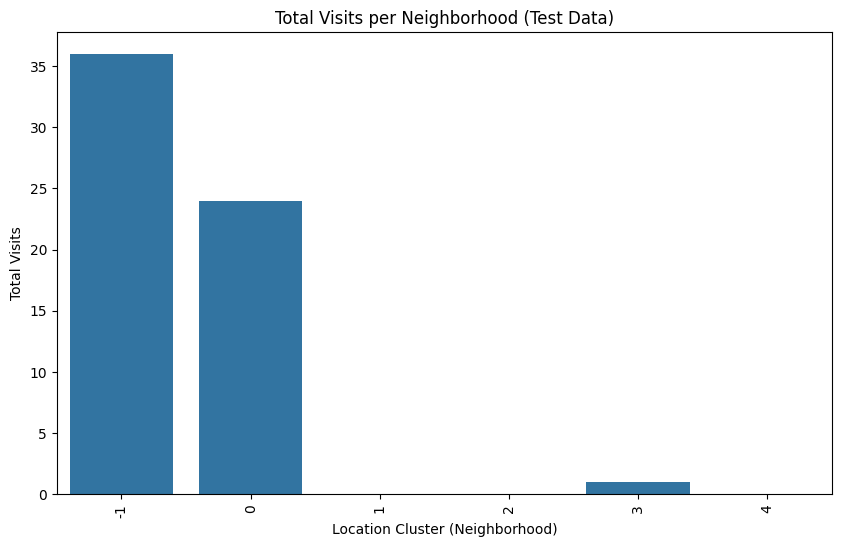

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Total visits per neighborhood
plt.figure(figsize=(10,6))
sns.barplot(x='location_cluster', y='total_visits_train', data=df)
plt.title('Total Visits per Neighborhood')
plt.xlabel('Location Cluster (Neighborhood)')
plt.ylabel('Total Visits')
plt.xticks(rotation=90)
plt.show()

# 2. Demand by Geographic Clusters
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
gdf.plot(column='hamper_visits', cmap='coolwarm', legend=True)
plt.title('Demand by Neighborhood')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 3. Unique Clients per Neighborhood
plt.figure(figsize=(10,6))
sns.barplot(x='location_cluster', y='unique_clients_per_neighborhood', data=df)
plt.title('Unique Clients per Neighborhood (Train Data)')
plt.xlabel('Location Cluster (Neighborhood)')
plt.ylabel('Unique Clients')
plt.xticks(rotation=90)
plt.show()

# 4. Distance to Distribution Center vs Demand
plt.figure(figsize=(10,6))
plt.scatter(df['distance_to_center'], df['hamper_visits'], alpha=0.5)
plt.title('Distance to Distribution Center vs. Demand')
plt.xlabel('Distance to Distribution Center (km)')
plt.ylabel('Hamper Visits')
plt.show()



### Creating the target column: Return_binary

How Rolling 60-Day Windows Work
For each pickup date, check if the client returns within the next 60 days.
Instead of just using consecutive visits, define the return_binary ("Yes"/"No") per rolling 60-day period.
This helps capture patterns across time even if a client has gaps in visits.

In [15]:
import pandas as pd

# Ensure 'pickup_date' is in datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])


# Sort data by client and pickup date
df = df.sort_values(by=['new_client_id', 'pickup_date'])


# Create a column for return classification
df['return_binary'] = "No"


# Compute next pickup date for each client
df['next_pickup_date'] = df.groupby('new_client_id')['pickup_date'].shift(-1)


# Check if the next pickup happens within 60 days
df['return_binary'] = (df['next_pickup_date'] - df['pickup_date']).dt.days <= 60
df['return_binary'] = df['return_binary'].map({True: "Yes", False: "No"})
# Drop unnecessary column if needed

df.drop(columns=['next_pickup_date'], inplace=True)





#**Block 5 - Correlation Analysis**

In [ ]:
# Create a label column for client retention
def create_label(df):
    df['retained'] = (df['total_visits_last_90d'] > 0).astype(int)  # If the client has visited in the last 90 days, they are considered retained.
    return df

df = create_label(df)



In [ ]:
import pandas as pd

# Assuming you have Train_dataDC and Test_dataDC DataFrames
# Merge both datasets (train and test) into one for overall comparison
df = pd.merge(df, how='outer')

# List of all features (including 'retained' for the comparison)
features_list = [
    'collect_scheduled_date', 'pickup_date', 'hamper_type', 'day_of_week',
    'month', 'is_muslim_holiday', 'is_ramadan_period', 'within_3_days_of_holiday',
    'during_ramadan', 'hamper_visits', 'total_visits_last_30d', 'avg_time_between_visits',
    'visit_frequency_category', 'time_since_first_visit', 'total_dependents', 'dependents_change_last_30d',
    'total_visits_last_7d', 'total_visits_last_14d', 'total_visits_last_90d', 'dependents_change_last_7d',
    'dependents_change_last_14d', 'dependents_change_last_90d', 'latitude', 'longitude',
    'distance_to_center', 'location_cluster', 'unique_clients_per_neighborhood', 'total_visits_train',
    'retained'  # Add the target variable for correlation comparison
]

# Function to split the features into chunks of 15
def split_features(features, chunk_size=15):
    return [features[i:i+chunk_size] for i in range(0, len(features), chunk_size)]

# Split the features into groups of 15
feature_groups = split_features(features_list)

# Calculate correlation of each feature in each group with the target 'retained'
import pandas as pd


# Calculate correlation of each feature in each group with the target 'retained'
correlation_results = {}
import pandas as pd


# Calculate correlation of each feature in each group with the target 'retained'
correlation_results = {}

for idx, group in enumerate(feature_groups):
    group_correlations = {}
    for feature in group:
        if feature != 'retained':  # Skip the target column itself
            # Check if the feature is 'hamper_type' or 'visit_frequency_category'
            # and convert to numeric if needed
            if feature in ['hamper_type', 'visit_frequency_category']:
                # Convert to numeric using Label Encoding
                df[feature + '_encoded'] = pd.factorize(df[feature])[0]
                correlation = df[feature + '_encoded'].corr(df['retained'])
            else:
                correlation = df[feature].corr(df['retained'])
            group_correlations[feature] = correlation
    correlation_results[f'Feature Group {idx+1}'] = group_correlations



# Display the results
for group, correlations in correlation_results.items():
    print(f"\n{group}:")
    for feature, correlation in correlations.items():
        print(f"  {feature}: {correlation:.2f}")



Feature Group 1:
  collect_scheduled_date: -0.67
  pickup_date: 0.45
  hamper_type: 0.01
  day_of_week: nan
  month: nan
  is_muslim_holiday: nan
  is_ramadan_period: nan
  within_3_days_of_holiday: 0.08
  during_ramadan: 0.16
  hamper_visits: 0.76
  total_visits_last_30d: 0.69
  avg_time_between_visits: nan
  visit_frequency_category: -0.80
  time_since_first_visit: nan
  total_dependents: 0.38

Feature Group 2:
  dependents_change_last_30d: nan
  total_visits_last_7d: 0.83
  total_visits_last_14d: 0.83
  total_visits_last_90d: 0.77
  dependents_change_last_7d: nan
  dependents_change_last_14d: nan
  dependents_change_last_90d: nan
  latitude: 0.01
  longitude: -0.04
  distance_to_center: -0.04
  location_cluster: 0.13
  unique_clients_per_neighborhood: 0.37
  total_visits_train: 0.08


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide



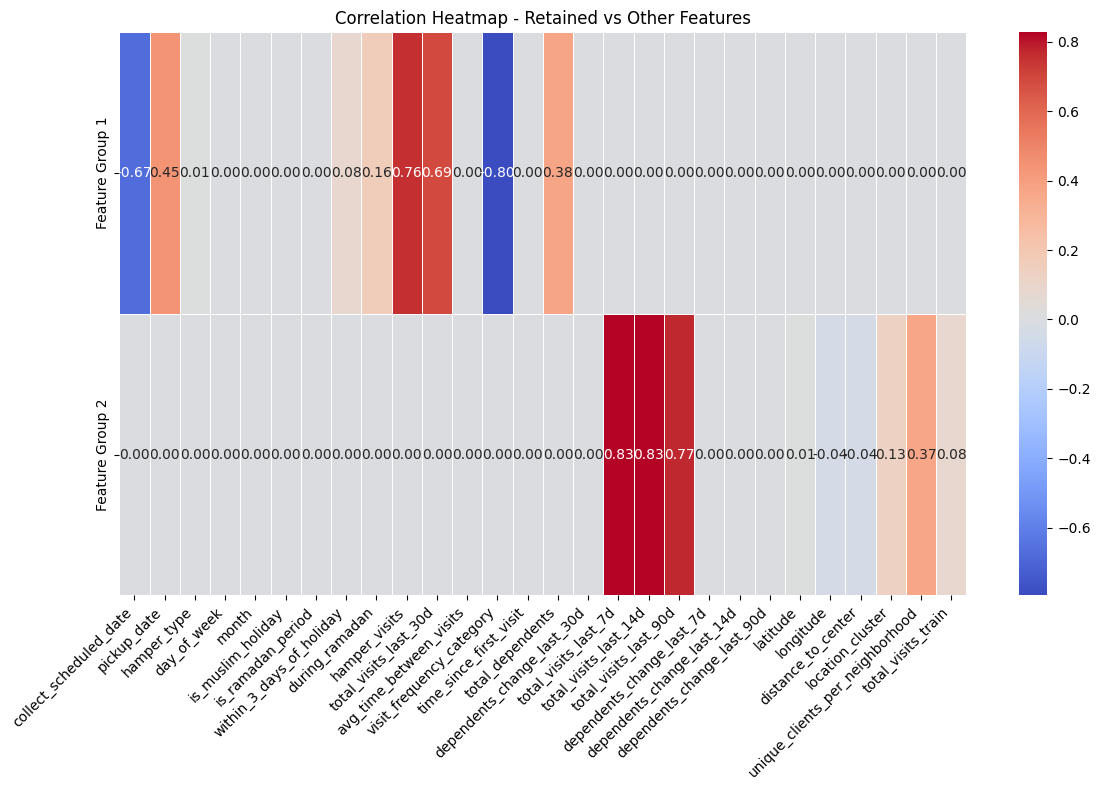

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# List of all features (including 'retained' for the comparison)
features_list = [
    'collect_scheduled_date', 'pickup_date', 'hamper_type', 'day_of_week',
    'month', 'is_muslim_holiday', 'is_ramadan_period', 'within_3_days_of_holiday',
    'during_ramadan', 'hamper_visits', 'total_visits_last_30d', 'avg_time_between_visits',
    'visit_frequency_category', 'time_since_first_visit', 'total_dependents', 'dependents_change_last_30d',
    'total_visits_last_7d', 'total_visits_last_14d', 'total_visits_last_90d', 'dependents_change_last_7d',
    'dependents_change_last_14d', 'dependents_change_last_90d', 'latitude', 'longitude',
    'distance_to_center', 'location_cluster', 'unique_clients_per_neighborhood', 'total_visits_train',
    'retained'  # Add the target variable for correlation comparison
]

# Function to split the features into chunks of 15
def split_features(features, chunk_size=15):
    return [features[i:i + chunk_size] for i in range(0, len(features), chunk_size)]

# Split the features into groups of 15
feature_groups = split_features(features_list)

# Calculate correlation of each feature in each group with the target 'retained'
correlation_results = {}

for idx, group in enumerate(feature_groups):
    group_correlations = {}
    for feature in group:
        if feature != 'retained':  # Skip the target column itself
            # Check if the feature is categorical and convert to numeric if needed
            if feature in ['hamper_type', 'visit_frequency_category']:
                # Convert to numeric using Label Encoding
                df[feature + '_encoded'] = pd.factorize(df[feature])[0]
                correlation = df[feature + '_encoded'].corr(df['retained'])
            else:
                correlation = df[feature].corr(df['retained'])
            group_correlations[feature] = correlation
    correlation_results[f'Feature Group {idx + 1}'] = group_correlations

# --- Heatmap Plotting ---
# Create a DataFrame from the correlation results
correlation_df = pd.DataFrame(correlation_results).T.fillna(0)  # Fill NaN with 0 for plotting

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap - Retained vs Other Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

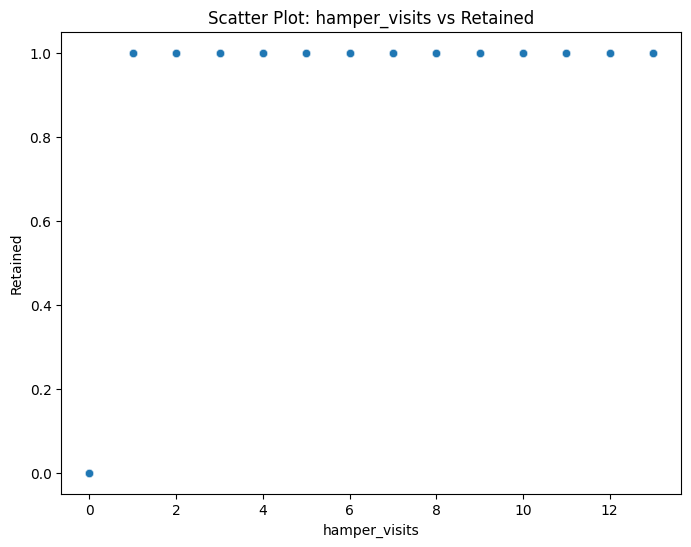

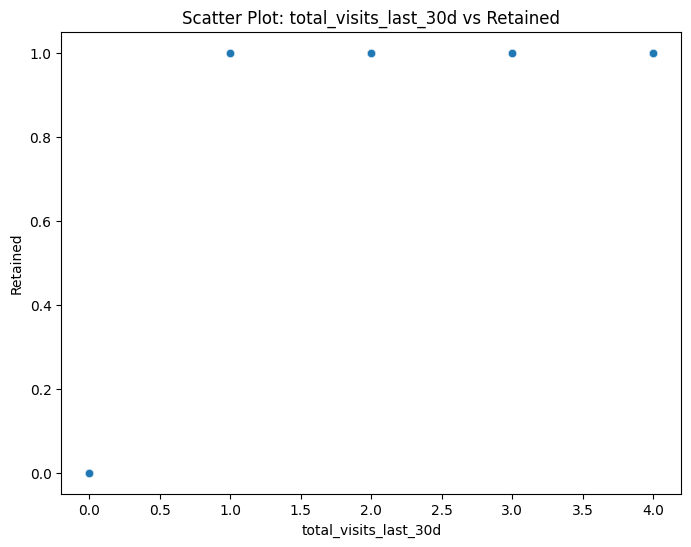

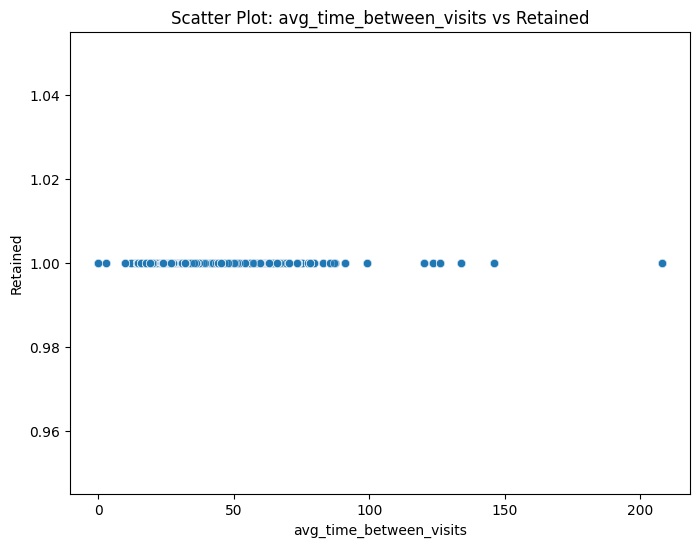

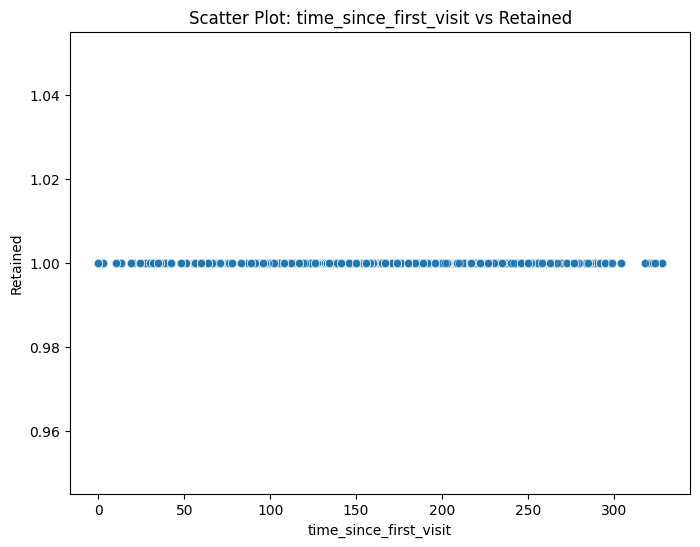

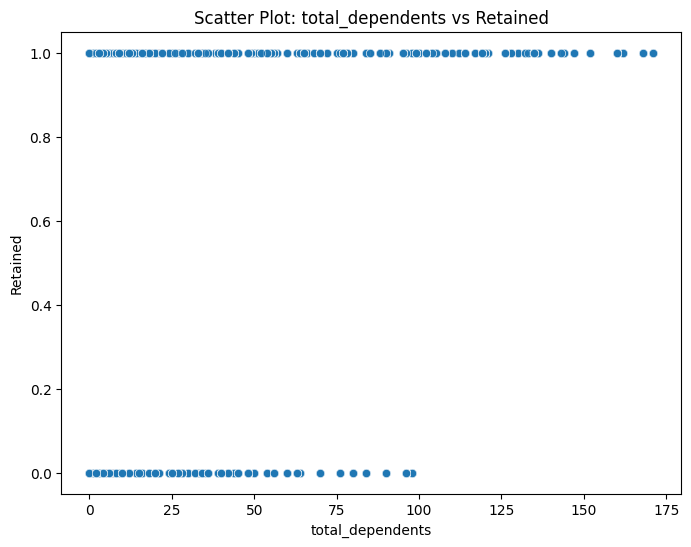

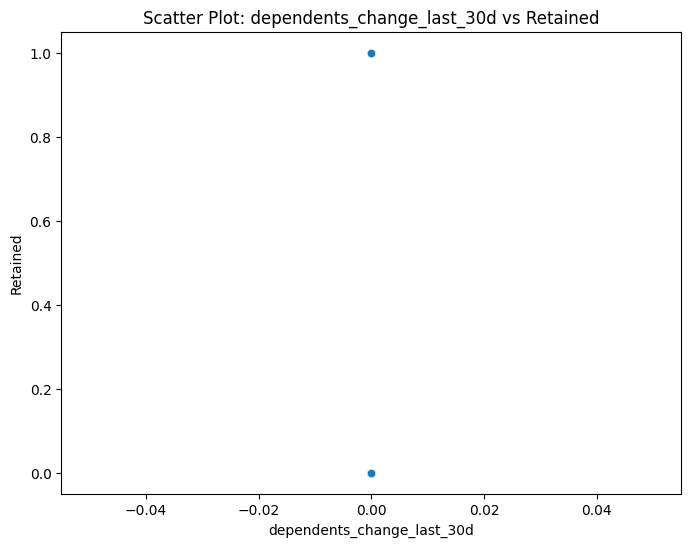

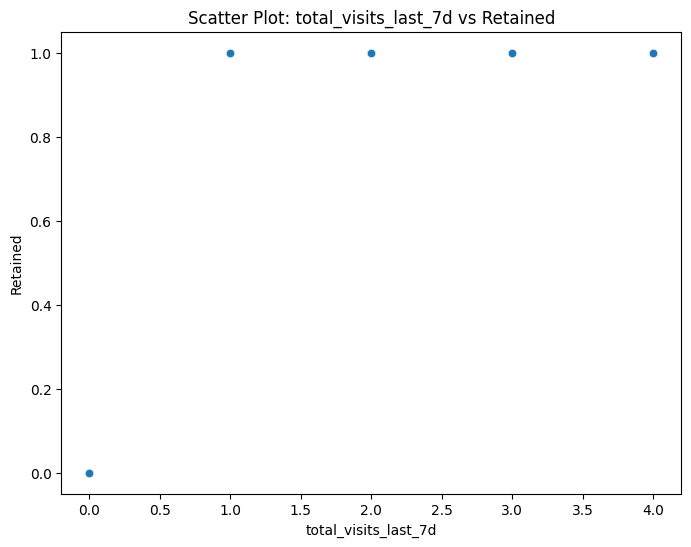

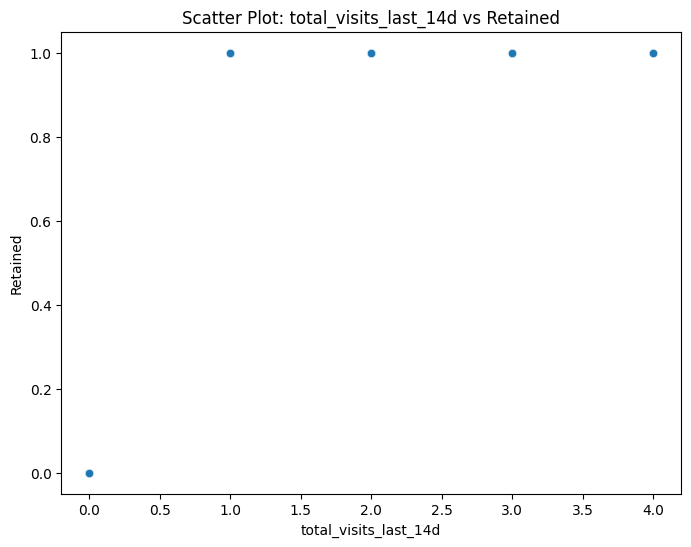

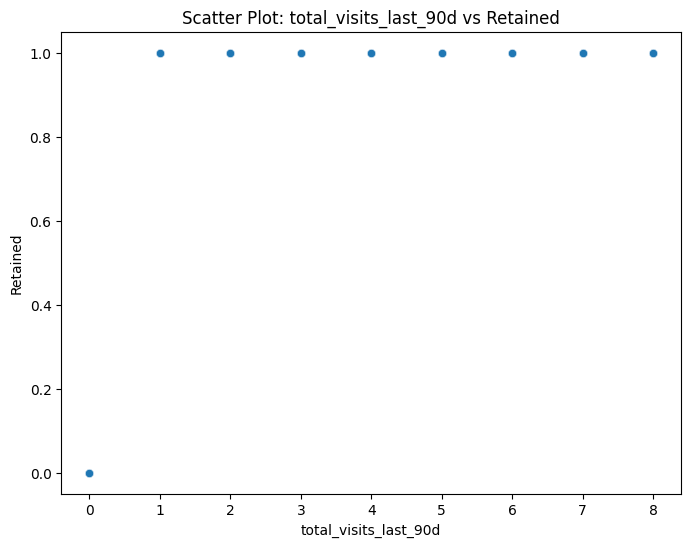

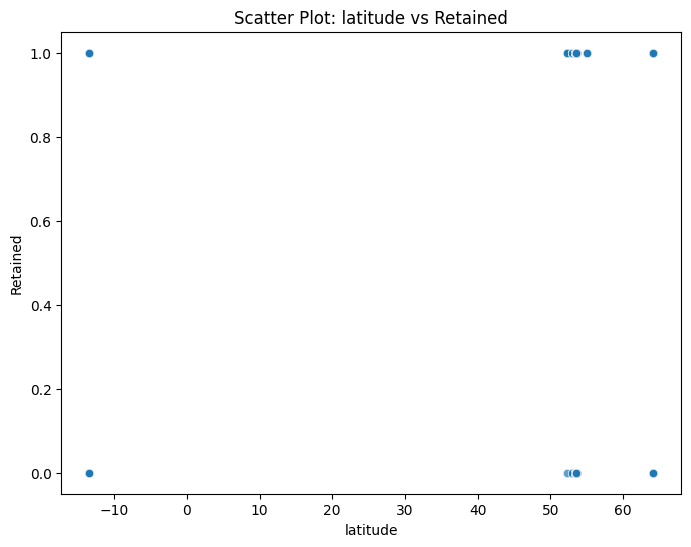

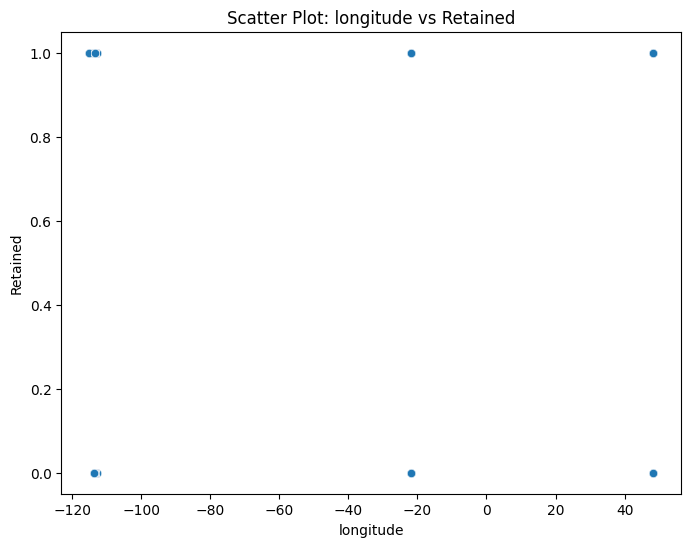

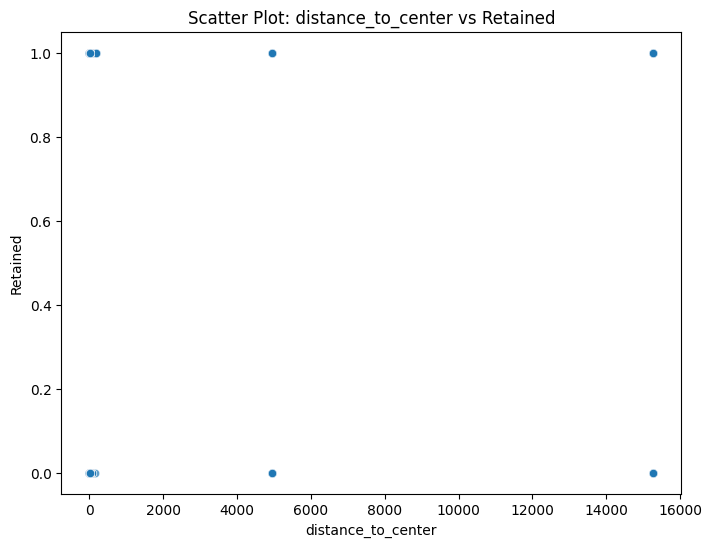

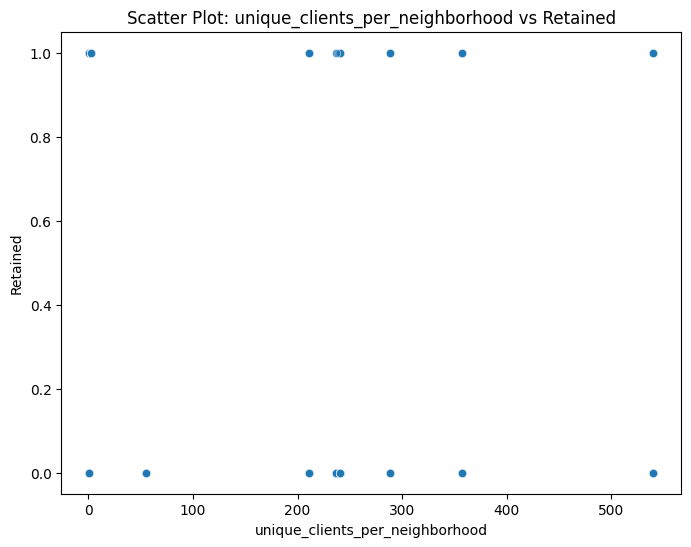

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of key numerical features to compare with 'retained'
key_features = [
    'hamper_visits', 'total_visits_last_30d', 'avg_time_between_visits',
    'time_since_first_visit', 'total_dependents', 'dependents_change_last_30d',
    'total_visits_last_7d', 'total_visits_last_14d', 'total_visits_last_90d',
    'latitude', 'longitude', 'distance_to_center', 'unique_clients_per_neighborhood'
]

# Plotting separate scatterplots for each feature vs retained
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature, y='retained', alpha=0.7)
    plt.title(f'Scatter Plot: {feature} vs Retained')
    plt.xlabel(feature)
    plt.ylabel('Retained')
    plt.show()


# Feature Refinement and Further Cleaning

### Checking for Outliers in Pickup and Scheduled Dates

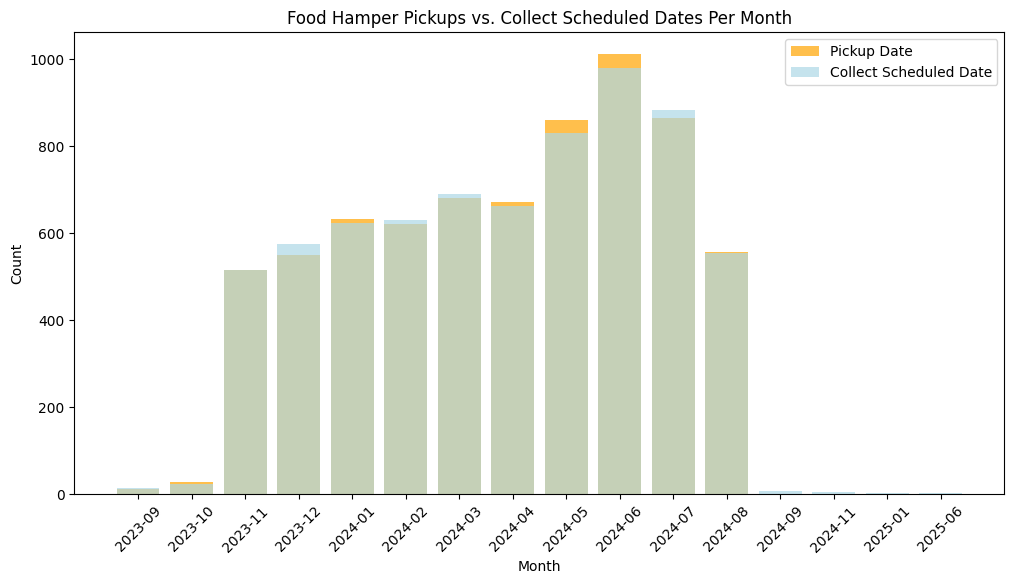

In [ ]:
import matplotlib.pyplot as plt

# Group by month for both pickup_date and collect_scheduled_date
pickup_counts = df.groupby(df["pickup_date"].dt.to_period("M")).size()
collect_counts = df.groupby(df["collect_scheduled_date"].dt.to_period("M")).size()

# Convert PeriodIndex to string for plotting
pickup_counts.index = pickup_counts.index.astype(str)
collect_counts.index = collect_counts.index.astype(str)

# Plot both on the same figure
plt.figure(figsize=(12, 6))
plt.bar(pickup_counts.index, pickup_counts, color="orange", alpha=0.7, label="Pickup Date")
plt.bar(collect_counts.index, collect_counts, color="lightblue", alpha=0.7, label="Collect Scheduled Date")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Food Hamper Pickups vs. Collect Scheduled Dates Per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()  # Add legend

plt.show()


In [ ]:
import pandas as pd

# Ensuring pickup_date' is in datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['collect_scheduled_date'] = pd.to_datetime(df['collect_scheduled_date'])

# Get the earliest (start) date
start_date = df['pickup_date'].min()
# Get the earliest (start) date
start_date = df['collect_scheduled_date'].min()

# Get the latest (end) date
end_date = df['pickup_date'].max()
# Get the latest (end) date
end_date = df['collect_scheduled_date'].max()

print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2023-11-01 13:37:00
End Date: 2024-08-26 15:13:00


We observe from the plot above that outliers exist in 2023-09, 2023-10, 2024-09 to 2025-06. We will drop these specified timeframes in the dataset

In [ ]:
# Ensure pickup_date is in datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
# Ensure collect_scheduled_date is in datetime format
df['collect_scheduled_date'] = pd.to_datetime(df['collect_scheduled_date'])

# Drop rows where pickup_date falls within the specified range
df = df[~df['pickup_date'].between('2023-09-07', '2023-10-31')]
# Drop rows where collect_scheduled_date falls within the specified range
df = df[~df['collect_scheduled_date'].between('2024-08-26', '2025-06-13')]


In [ ]:
# download df as csv
df.to_csv('df.csv', index=False)